# Binary Classification Prediction Visualization

In [2]:
#!pwd
%cd ../../src

C:\Users\Felix\code\uni\UniVie\master-thesis\src


C:\Users\Felix\code\uni\UniVie\master-thesis\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
import torch
import pickle
import platform
import pandas as pd
import numpy as np
from itertools import compress
import matplotlib.pylab as plt
from matplotlib import font_manager as fm

import experiments.visualisation.vis_utils
from experiments.visualisation.custom_colors import blue_shades

plt.style.use('default')

font_path = r'C:\Users\Felix\AppData\Local\Microsoft\Windows\Fonts\SourceSansPro-Regular.ttf'
fm.fontManager.addfont(font_path)
source_sans_pro = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = source_sans_pro.get_name()

In [4]:
STORE = False
# STORE = True

In [5]:
from utils.knowledge_db import TOKENS, CODON_MAP_DNA, TISSUES
INV_CODON_MAP_DNA = {v: k for k, v in CODON_MAP_DNA.items()}
TISSUES_DICT = {k: v for k, v in enumerate(TISSUES)}

# TODO print tissue name and if tissue is already identified as GC or AT favouring based on Hernandez-Alias et al
tissue_numbers = {
    "GC": [11, 19, 10, 15],  # Kidney, Rectum, Heart, Ovary
    "AT": [13, 2, 25, 4]     # Lung, Brain, Testis, Duodenum
}

## CLASSIFICATION

In [36]:
# best model (pretrained PTRnet)
predictions_path = "/export/share/krausef99dm/runs/binary/ptrnet/31_ptrnet_freq/predictions"

# freq MLP model (from benchmarking)
predictions_path_baseline = "/export/share/krausef99dm/runs/binary/baseline/6_baseline_freq/predictions"

path_seq_val = "/export/share/krausef99dm/data/data_test/test_9.0k_data.pkl"

In [37]:
df_val = pd.read_csv(os.path.join(predictions_path, "predictions_val_fold-0.csv"), index_col=0)
df_val_baseline = pd.read_csv(os.path.join(predictions_path_baseline, "predictions_val_fold-0.csv"), index_col=0)

In [38]:
df_val

,tissue_ids,target,prediction
0,6,1,0.340291
1,16,0,0.534514
2,1,1,0.310510
3,8,0,0.282197
4,3,1,0.300825
...,...,...,...
2768,24,0,0.642258
2769,21,0,0.781745
2770,23,1,0.582704
2771,8,1,0.273913


In [39]:
# load val data
with open(path_seq_val, 'rb') as f:
    rna_data, tissue_ids, targets, targets_bin =  pickle.load(f)

In [40]:
# filter data
mask = torch.ones((len(rna_data)), dtype=torch.bool)
mask_bin = targets_bin > 0  # only keep low-/high-PTR samples
mask = mask_bin & mask
#targets_bin -= 1  # make binary class 0/1 encoded

mask_len = torch.tensor([len(d) <= 9000 for d in rna_data])
mask = mask_len & mask

rna_data_masked = list(compress(rna_data, mask))
tissue_ids_masked = list(compress(tissue_ids.tolist(), mask))

In [41]:
len(rna_data_masked)

2773

In [42]:
#df_val["rna_data"] = rna_data_masked
df_val["prediction_bin"] = [1 if i > 0.5 else 0 for i in df_val.prediction]
df_val["correct_pred"] = df_val.target == df_val.prediction_bin

df_val["prediction_freq"] = df_val_baseline.prediction
df_val["prediction_bin_freq"] = [1 if i > 0.5 else 0 for i in df_val.prediction_freq]
df_val["correct_pred_freq"] = df_val.target == df_val.prediction_bin_freq

df_val = df_val.rename(columns={"tissue_ids": "tissue_id"})

#df_val["tissue_id"] = tissue_ids_masked

rna_numeric = ["".join(list(map(str, rna_data_masked[i][:, 0].tolist()))) for i in range(len(rna_data_masked))]
df_val["rna"] = ["".join([TOKENS[int(i) - 1] for i in rna]) for rna in rna_numeric]
df_val["coding_area"] = ["".join(list(map(str, rna_data_masked[i][:, 1].tolist()))) for i in range(len(rna_data_masked))]
df_val["seq_len"] = [len(rna) for rna in rna_data_masked]

In [43]:
df_val

,tissue_id,target,prediction,prediction_bin,correct_pred,prediction_freq,prediction_bin_freq,correct_pred_freq,rna,coding_area,seq_len
0,6,1,0.340291,0,False,0.161814,0,False,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193
1,16,0,0.534514,1,False,0.559810,1,False,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193
2,1,1,0.310510,0,False,0.279136,0,False,TCCCCTTGGCCCTCCCTTACCGCACGGTCTCTGGCCAGCCGTGGCC...,5555555555555555555555555555555555555555555555...,1761
3,8,0,0.282197,0,True,0.274266,0,True,TCCCCTTGGCCCTCCCTTACCGCACGGTCTCTGGCCAGCCGTGGCC...,5555555555555555555555555555555555555555555555...,1761
4,3,1,0.300825,0,False,0.213903,0,False,GCGTCCGCGCCATCAGGCCCGAGATAGCGGCGAGGTCCGCTTTCAG...,5555555555555555555555555555555555555555555555...,2767
...,...,...,...,...,...,...,...,...,...,...,...
2768,24,0,0.642258,1,False,0.415386,0,False,CTCGGCGATGAGCTAAGACGCTGTTTCAGAGCGTTTGGGTCCTCTG...,5555555555555555555555555555555555555555555555...,1998
2769,21,0,0.781745,1,False,0.814679,1,False,ACATTGGGGCGGGATGTGGGAGCGGCTGAACTGCGCAGCAGAGGAC...,5555555555555123123123123123123123123123123123...,3595
2770,23,1,0.582704,1,True,0.601535,1,True,ACATTGGGGCGGGATGTGGGAGCGGCTGAACTGCGCAGCAGAGGAC...,5555555555555123123123123123123123123123123123...,3595
2771,8,1,0.273913,0,False,0.400855,0,False,GGAGTCTGCGCTCTGGTTCGGGCTGCGGCTGCGGCTGCGGCTGCGG...,5555555555555555555555555555555555555555555555...,8143


## Checkpoint

In [44]:
# store df_val
# df_val.to_csv("../experiments/visualisation/data/ptrnet_31_preds_extended.csv")

In [375]:
# load df_val
df = pd.read_csv("../experiments/visualisation/data/ptrnet_31_preds_extended.csv", index_col=0)

In [376]:
# CORRECTING CODE BUG IN CURRENT DATA
df["correct_pred_freq"] = df.target == df.prediction_bin_freq

## Tissue-wise AUC and F1

In [377]:
# Load Hernandez results from excel
hernandez_df = pd.read_excel("../experiments/visualisation/data/Hernandez-Alias_results.xlsx", sheet_name="RandomForest")
hernandez_df = hernandez_df[["Unnamed: 0", "roc_auc"]]
hernandez_df.columns = ["Tissue", "Hernandez-Alias cv AUC"]
hernandez_df

,Tissue,Hernandez-Alias cv AUC
0,Adrenal,0.575147
1,Appendices,0.595536
2,Artery,0.651098
3,Brain,0.666818
4,Breast,0.758950
5,Colon,0.698722
6,Duodenum,0.673955
7,Esophagus,0.532194
8,Fallopiantube,0.639287
9,Fat,0.608066


In [378]:
from sklearn.metrics import f1_score, roc_auc_score

results = []

for group in df.tissue_id.unique():
    idx = df.tissue_id == group

    f1 = f1_score(df.target[idx], df.prediction_bin[idx])
    f1_freq = f1_score(df.target[idx], df.prediction_bin_freq[idx])

    auc = roc_auc_score(df.target[idx], df.prediction[idx])
    auc_freq = roc_auc_score(df.target[idx], df.prediction_freq[idx])

    # bool if simply majority classification
    majority_class = df.target[idx].mode()[0]
    is_majority_baseline = (df.prediction_bin[idx] == majority_class).all()
    is_majority_baseline_freq = (df.prediction_bin_freq[idx] == majority_class).all()

    results.append({
        "tissue_id": group,
        "f1": f1,
        "f1_freq": f1_freq,
        "auc": auc,
        "auc_freq": auc_freq,
        "is_majority_baseline": is_majority_baseline,
        "is_majority_baseline_freq": is_majority_baseline_freq,
    })

df_results = pd.DataFrame(results)
df_results.loc[:, "tissue"] = df_results.tissue_id.map(TISSUES_DICT)
df_results

,tissue_id,f1,f1_freq,auc,auc_freq,is_majority_baseline,is_majority_baseline_freq,tissue
0,6,0.000000,0.055556,0.489885,0.495353,True,False,Esophagus
1,16,0.531250,0.550000,0.667925,0.706113,False,False,Pancreas
2,1,0.000000,0.196078,0.575647,0.666841,True,False,Appendices
3,8,0.000000,0.048780,0.609893,0.660819,True,False,Fat
4,3,0.531250,0.727273,0.666851,0.797672,False,False,Colon
5,14,0.626866,0.677419,0.632000,0.796571,False,False,Lymphnode
6,28,0.000000,0.300000,0.564516,0.490323,True,False,Urinarybladder
7,9,0.333333,0.410256,0.585455,0.658182,False,False,Gallbladder
8,10,0.037736,0.475000,0.435185,0.654412,False,False,Heart
9,4,0.468085,0.521739,0.621176,0.732941,False,False,Duodenum


In [305]:
df_results_clean = df_results.copy()
df_results_clean.sort_values(by="auc", ascending=False, inplace=True)
df_results_clean = df_results_clean[["tissue", "auc", "auc_freq", "is_majority_baseline", "is_majority_baseline_freq"]]
df_results_clean.columns = ["Tissue", "PTRnet test AUC", "MLP (freq) test AUC", "PTRnet only majority prediction", "MLP (freq) only majority prediction"]
df_results_clean

,Tissue,PTRnet test AUC,MLP (freq) test AUC,PTRnet only majority prediction,MLP (freq) only majority prediction
13,Kidney,0.814516,0.838710,False,False
23,Prostate,0.794434,0.751423,False,False
18,Thyroid,0.752397,0.767808,False,False
19,Rectum,0.721379,0.606897,False,False
10,Lung,0.715622,0.797529,False,False
17,Salivarygland,0.711785,0.800673,False,False
26,Smallintestine,0.710591,0.779557,False,False
27,Tonsil,0.693023,0.761395,False,False
1,Pancreas,0.667925,0.706113,False,False
4,Colon,0.666851,0.797672,False,False


In [306]:
# merge
tissue_results_df = pd.merge(df_results_clean, hernandez_df, on="Tissue", how="left")
tissue_results_df = tissue_results_df.round(4)
tissue_results_df = tissue_results_df[['Tissue', 'PTRnet test AUC', 'MLP (freq) test AUC', 'Hernandez-Alias cv AUC', 'PTRnet only majority prediction', 'MLP (freq) only majority prediction']]
tissue_results_df

,Tissue,PTRnet test AUC,MLP (freq) test AUC,Hernandez-Alias cv AUC,PTRnet only majority prediction,MLP (freq) only majority prediction
0,Kidney,0.8145,0.8387,0.7896,False,False
1,Prostate,0.7944,0.7514,0.6252,False,False
2,Thyroid,0.7524,0.7678,0.6304,False,False
3,Rectum,0.7214,0.6069,0.7113,False,False
4,Lung,0.7156,0.7975,0.7144,False,False
5,Salivarygland,0.7118,0.8007,0.6179,False,False
6,Smallintestine,0.7106,0.7796,0.6106,False,False
7,Tonsil,0.6930,0.7614,0.7097,False,False
8,Pancreas,0.6679,0.7061,0.6177,False,False
9,Colon,0.6669,0.7977,0.6987,False,False


In [307]:
tissue_results_df.to_latex()

'\\begin{tabular}{llrrrrr}\n\\toprule\n & Tissue & PTRnet test AUC & MLP (freq) test AUC & Hernandez-Alias cv AUC & PTRnet only majority prediction & MLP (freq) only majority prediction \\\\\n\\midrule\n0 & Kidney & 0.814500 & 0.838700 & 0.789600 & False & False \\\\\n1 & Prostate & 0.794400 & 0.751400 & 0.625200 & False & False \\\\\n2 & Thyroid & 0.752400 & 0.767800 & 0.630400 & False & False \\\\\n3 & Rectum & 0.721400 & 0.606900 & 0.711300 & False & False \\\\\n4 & Lung & 0.715600 & 0.797500 & 0.714400 & False & False \\\\\n5 & Salivarygland & 0.711800 & 0.800700 & 0.617900 & False & False \\\\\n6 & Smallintestine & 0.710600 & 0.779600 & 0.610600 & False & False \\\\\n7 & Tonsil & 0.693000 & 0.761400 & 0.709700 & False & False \\\\\n8 & Pancreas & 0.667900 & 0.706100 & 0.617700 & False & False \\\\\n9 & Colon & 0.666900 & 0.797700 & 0.698700 & False & False \\\\\n10 & Stomach & 0.666700 & 0.651300 & 0.500800 & False & False \\\\\n11 & Lymphnode & 0.632000 & 0.796600 & 0.670100 & Fa

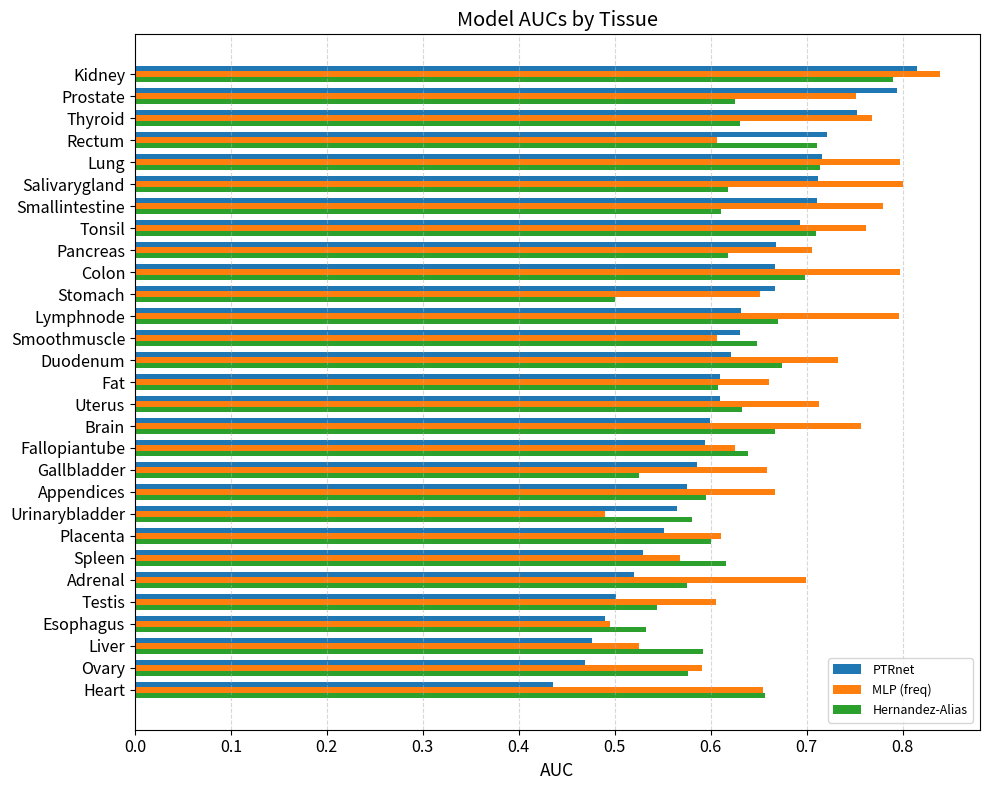

In [40]:
df_sorted = tissue_results_df.sort_values("PTRnet test AUC", ascending=True)
fig, ax = plt.subplots(figsize=(10, 8))
bar_width = 0.25
y_pos = range(len(df_sorted))

ax.barh(
    [y + bar_width for y in y_pos],
    df_sorted["PTRnet test AUC"],
    height=bar_width,
    label="PTRnet"
)
ax.barh(
    y_pos,
    df_sorted["MLP (freq) test AUC"],
    height=bar_width,
    label="MLP (freq)"
)
ax.barh(
    [y - bar_width for y in y_pos],
    df_sorted["Hernandez-Alias cv AUC"],
    height=bar_width,
    label="Hernandez-Alias"
)

ax.set_yticks(y_pos)
ax.set_yticklabels(df_sorted["Tissue"])
ax.set_xlabel("AUC")
ax.set_title("Model AUCs by Tissue")
ax.legend()
plt.tight_layout()
plt.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

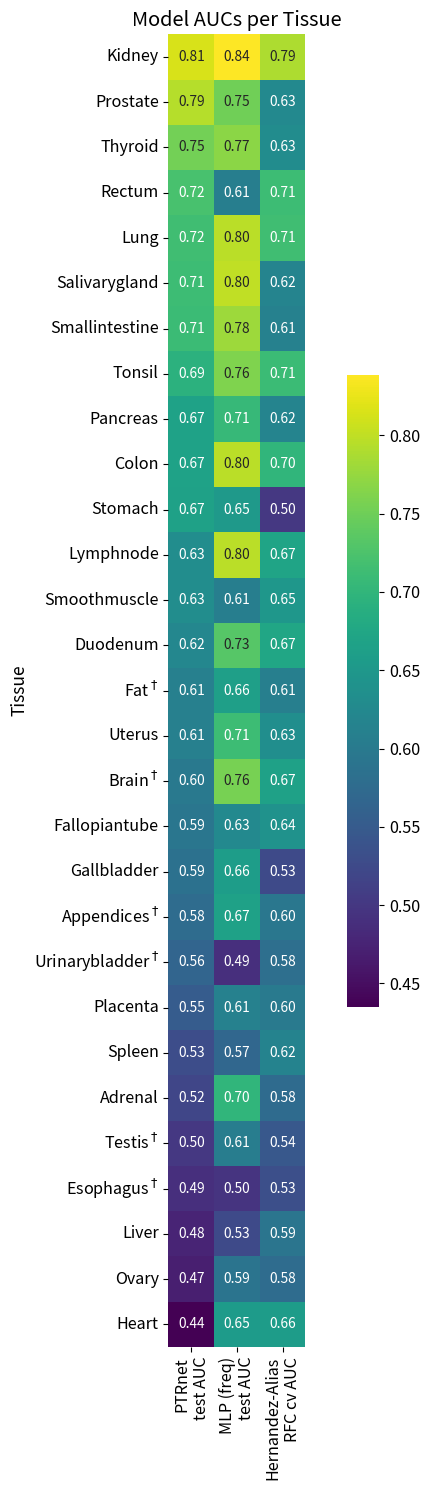

In [412]:
import seaborn as sns

plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13
})

df_heat = tissue_results_df[["Tissue", "PTRnet test AUC", "MLP (freq) test AUC", "Hernandez-Alias cv AUC"]].set_index("Tissue")
df_heat.columns = ['PTRnet\ntest AUC', 'MLP (freq)\ntest AUC', 'Hernandez-Alias\nRFC cv AUC']

# Marking the models with majority votings
df_heat.rename(index={"Fat": "Fat$^\dagger$",
                    "Brain": "Brain$^\dagger$",
                    "Appendices": "Appendices$^\dagger$",
                    "Urinarybladder": "Urinarybladder$^\dagger$",
                    "Testis": "Testis$^\dagger$",
                    "Esophagus": "Esophagus$^\dagger$"},
               inplace=True)

plt.figure(figsize=(4.4, 15))
ax = sns.heatmap(df_heat, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'pad': 0.2}, annot_kws={"fontsize": 11})

# Center and rotate y-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, rotation_mode='anchor')
for label in ax.get_xticklabels():
    label.set_ha('right')  # keep it centered under tick
    label.set_va('center')  # align top of text box to bottom of tick

# cbar = ax.collections[0].colorbar
# vmin, vmax = df_heat.min().min(), df_heat.max().max()
# ticks = np.linspace(vmin, vmax, num=4)
# cbar.set_ticks(ticks)

plt.title("Model AUCs per Tissue")
plt.ylabel("Tissue")
plt.tight_layout()

if STORE:
    plt.savefig(os.getenv("OUTPUT_DIR") + f"/model_auc_per_tissue.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [45]:
tissue_results_df.to_latex()

'\\begin{tabular}{llrr}\n\\toprule\n & Tissue & test AUC & Hernandez cv AUC \\\\\n\\midrule\n0 & Kidney & 0.814500 & 0.789600 \\\\\n1 & Prostate & 0.794400 & 0.625200 \\\\\n2 & Thyroid & 0.752400 & 0.630400 \\\\\n3 & Rectum & 0.721400 & 0.711300 \\\\\n4 & Lung & 0.715600 & 0.714400 \\\\\n5 & Salivarygland & 0.711800 & 0.617900 \\\\\n6 & Smallintestine & 0.710600 & 0.610600 \\\\\n7 & Tonsil & 0.693000 & 0.709700 \\\\\n8 & Pancreas & 0.667900 & 0.617700 \\\\\n9 & Colon & 0.666900 & 0.698700 \\\\\n10 & Stomach & 0.666700 & 0.500800 \\\\\n11 & Lymphnode & 0.632000 & 0.670100 \\\\\n12 & Smoothmuscle & 0.631000 & 0.648100 \\\\\n13 & Duodenum & 0.621200 & 0.674000 \\\\\n14 & Fat & 0.609900 & 0.608100 \\\\\n15 & Uterus & 0.609200 & 0.632300 \\\\\n16 & Brain & 0.598800 & 0.666800 \\\\\n17 & Fallopiantube & 0.593800 & 0.639300 \\\\\n18 & Gallbladder & 0.585500 & 0.525500 \\\\\n19 & Appendices & 0.575600 & 0.595500 \\\\\n20 & Urinarybladder & 0.564500 & 0.580400 \\\\\n21 & Placenta & 0.551300 & 0

## Feature engineering

### 3' and 5' UTR lengths

In [379]:
df.loc[:, "5_utr_len"] = [seq.count("5") for seq in df.coding_area]
df.loc[:, "3_utr_len"] = [seq.count("3") for seq in df.coding_area]
df.loc[:, "cds_len"] = [len(seq) - seq.count("5") - seq.count("3") for seq in df.coding_area]

### Kozak Sequence Presence

In [380]:
import re

def has_kozak(seq, window=10):
    """
    Checks if a sequence contains a Kozak-like motif around AUG.
    Returns True if a strong Kozak is found.
    """
    pattern = re.compile(r'[AG]{1}.{2}ATGG')  # Simple Kozak: RXXAUGG
    for match in re.finditer(r'ATG', seq):
        start = match.start()
        context = seq[max(0, start-6):start+4]  # −6 to +4 around AUG
        if pattern.search(context):
            return True, context
    return False, None

In [381]:
# Basically all sequences have the Kozak sequence acc. to ChatGPT definition
counter = 0

for rna in df.rna:
    if has_kozak(rna)[0]:
        # print(has_kozak(rna))
        counter += 1

print(counter)

2741


### Total GC content

In [383]:
# legacy
def compute_gc_content(encoded_str: str) -> float:
    """
    Compute GC content from a string of token indices (as characters).
    """
    decoded = [TOKENS[int(ch)-1] for ch in encoded_str if ch.isdigit()]
    gc_count = sum(1 for base in decoded if base in ['G', 'C'])
    valid_bases = sum(1 for base in decoded if base in ['A', 'C', 'G', 'T'])
    return gc_count / valid_bases if valid_bases > 0 else 0.0

In [384]:
# new
def gc_ending_codon_fraction(seq):
    codons = [seq[i:i+3] for i in range(0, len(seq) - len(seq) % 3, 3)]
    gc_ending = [c for c in codons if c[-1] in {'G', 'C'}]
    return len(gc_ending) / len(codons) if codons else 0

In [385]:
df.loc[:, "gc_content"] = df["rna"].apply(gc_ending_codon_fraction)

In [227]:
df

,tissue_id,target,prediction,prediction_bin,correct_pred,prediction_freq,prediction_bin_freq,correct_pred_freq,rna,coding_area,seq_len,5_utr_len,3_utr_len,gc_content,cds_len
0,6,1,0.340291,0,False,0.161814,0,False,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193,209,426,0.461012,1558
1,16,0,0.534514,1,False,0.559810,1,False,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193,209,426,0.461012,1558
2,1,1,0.310510,0,False,0.279136,0,False,TCCCCTTGGCCCTCCCTTACCGCACGGTCTCTGGCCAGCCGTGGCC...,5555555555555555555555555555555555555555555555...,1761,142,416,0.504259,1203
3,8,0,0.282197,0,True,0.274266,0,True,TCCCCTTGGCCCTCCCTTACCGCACGGTCTCTGGCCAGCCGTGGCC...,5555555555555555555555555555555555555555555555...,1761,142,416,0.504259,1203
4,3,1,0.300825,0,False,0.213903,0,False,GCGTCCGCGCCATCAGGCCCGAGATAGCGGCGAGGTCCGCTTTCAG...,5555555555555555555555555555555555555555555555...,2767,49,310,0.364425,2408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,24,0,0.642258,1,False,0.415386,0,False,CTCGGCGATGAGCTAAGACGCTGTTTCAGAGCGTTTGGGTCCTCTG...,5555555555555555555555555555555555555555555555...,1998,127,479,0.373874,1392
2769,21,0,0.781745,1,False,0.814679,1,False,ACATTGGGGCGGGATGTGGGAGCGGCTGAACTGCGCAGCAGAGGAC...,5555555555555123123123123123123123123123123123...,3595,13,592,0.319699,2990
2770,23,1,0.582704,1,True,0.601535,1,True,ACATTGGGGCGGGATGTGGGAGCGGCTGAACTGCGCAGCAGAGGAC...,5555555555555123123123123123123123123123123123...,3595,13,592,0.319699,2990
2771,8,1,0.273913,0,False,0.400855,0,False,GGAGTCTGCGCTCTGGTTCGGGCTGCGGCTGCGGCTGCGGCTGCGG...,5555555555555555555555555555555555555555555555...,8143,201,745,0.395357,7197


## Analysis

### Descriptive analysis

<Axes: >

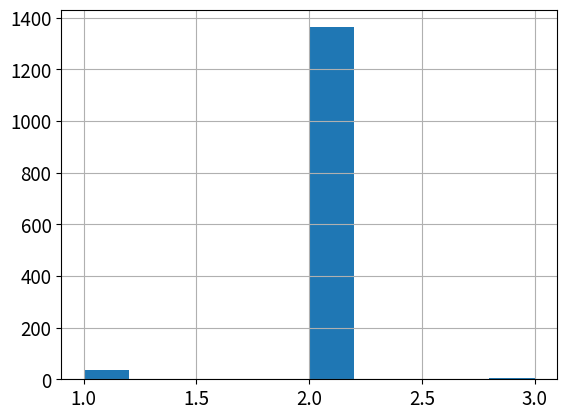

In [386]:
# almost all sequences appear twice (in val set)
nr_seq_appearance_grouped_df =  df.groupby("rna").tissue_id.count()
nr_seq_appearance_grouped_df.hist()

In [346]:
nr_seq_appearance_grouped_df.value_counts()

tissue_id
2    1363
1      35
3       4
Name: count, dtype: int64

<Axes: >

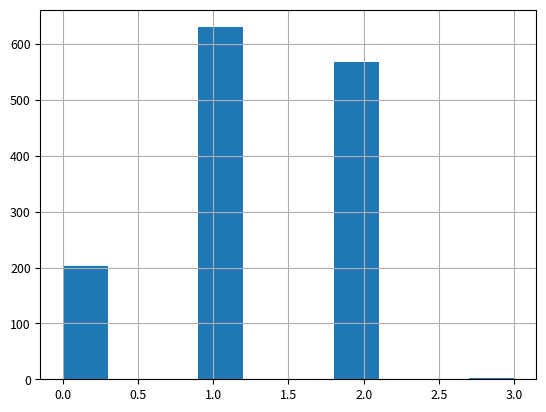

In [309]:
correct_pred_grouped_df = df.groupby("rna").correct_pred.sum()#.groupby("correct_pred").count()#.hist(density=True)
correct_pred_grouped_df = pd.concat([nr_seq_appearance_grouped_df, correct_pred_grouped_df], axis=1)
#correct_pred_grouped_df.loc[:, "all_correct"] = correct_pred_grouped_df.tissue_id == correct_pred_grouped_df.correct_pred
correct_pred_grouped_df.correct_pred.hist()

# 0: low- and high PTR sample of mRNA classified wrong: around 17%
# 1: only one of both is classified correctly: around 43%
# 2: both are correctly predicted: 39%

In [310]:
# PTRnet
print(correct_pred_grouped_df.value_counts())

tissue_id  correct_pred
2          1               602
           2               566
           0               195
1          1                28
           0                 7
3          2                 2
           3                 2
Name: count, dtype: int64


In [311]:
# MLP (freq)
correct_pred_grouped_df_freq = df.groupby("rna").correct_pred_freq.sum()#.groupby("correct_pred").count()#.hist(density=True)
correct_pred_grouped_df_freq = pd.concat([nr_seq_appearance_grouped_df, correct_pred_grouped_df_freq], axis=1)
print(correct_pred_grouped_df_freq.value_counts())

tissue_id  correct_pred_freq
2          2                    623
           1                    567
           0                    173
1          1                     27
           0                      8
3          2                      2
           1                      1
           3                      1
Name: count, dtype: int64


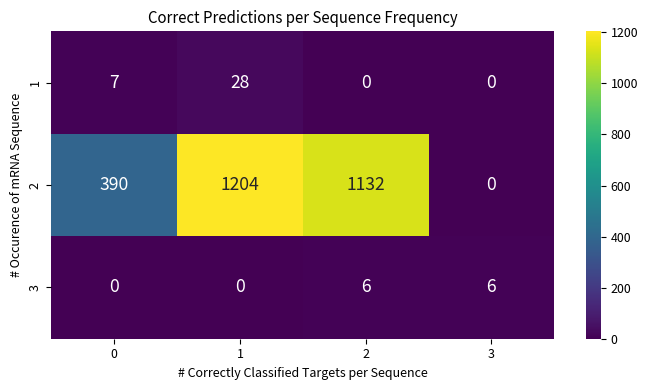

In [312]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

data = {
    'nr_seq': [2, 2, 2, 1, 1, 3, 3, 3],
    'correct_pred': [1, 2, 0, 1, 0, 2, 3, 1],
    'count': [602*2, 566*2, 195*2, 28, 7, 2*3, 2*3, 0],
    'count_freq': [567*2, 623*2, 173*2, 27, 8, 2*3, 1*3, 1*3]
}
df_corr_pred_seq_freq = pd.DataFrame(data)

# Pivot for stacked bar
pivot = df_corr_pred_seq_freq.pivot(index='nr_seq', columns='correct_pred', values='count').fillna(0).astype(int)
pivot = pivot.sort_index()

cmap = LinearSegmentedColormap.from_list("white_to_blue", ["white", blue_shades[-1]])

plt.figure(figsize=(7, 4))  # Adjust width and height as needed

sns.heatmap(pivot, annot=True, fmt="d", cmap="viridis", annot_kws={"fontsize": 14})
plt.xlabel("# Correctly Classified Targets per Sequence")
plt.ylabel("# Occurence of mRNA Sequence")
plt.title("Correct Predictions per Sequence Frequency")
plt.tight_layout()

# if STORE:
#     plt.savefig(os.getenv("OUTPUT_DIR") + f"/correct_predictions_per_seq_freq.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [222]:
# TODO check above - why some counts lost?

(2773, 11)

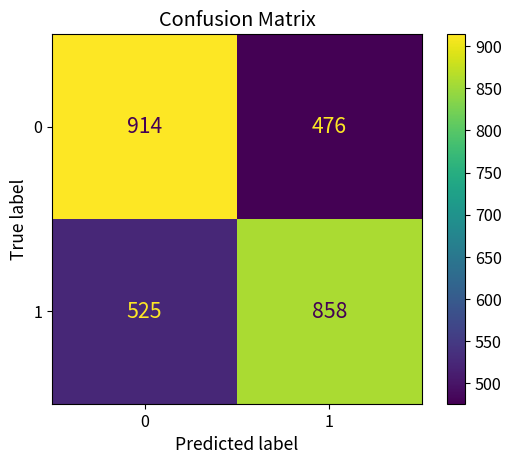

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df.target, df.prediction_bin)


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(text_kw={'fontsize': 17})
plt.title("Confusion Matrix")
plt.show()

In [340]:
STORE = True

In [343]:
sum([567*2, 623*2, 173*2, 27, 8, 2*3, 1*3, 1*3])

2773

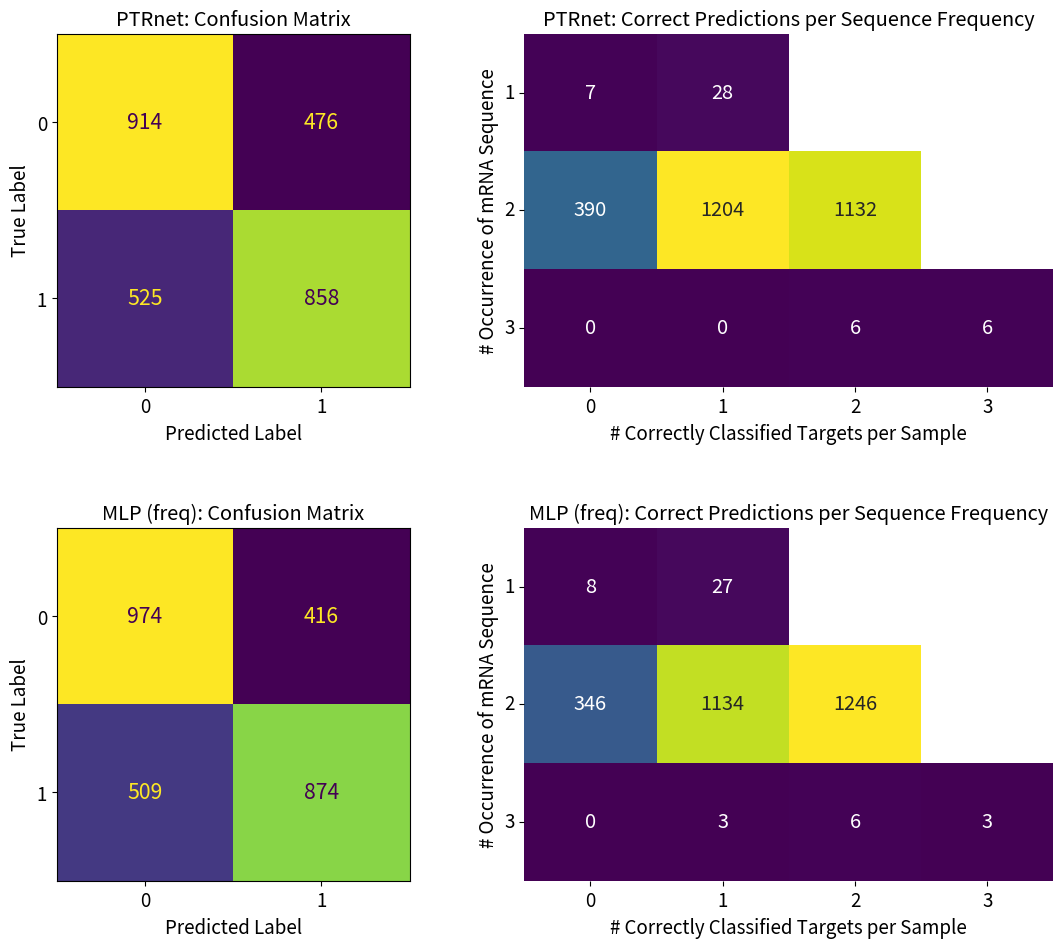

In [415]:
# PTRnet vs. MLP (freq)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import os

plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
})

# --- Data and Preparation ---
data = {
    'nr_seq':       [2,      2,      2,     2,     1,  1,    1,      1,     3, 3, 3, 3],
    'correct_pred': [1,      2,      0,     3,     1,  0,    2,      3,     2, 3, 1, 0],
    'count':        [602*2, 566*2, 195*2, np.nan, 28,  7,  np.nan, np.nan, 2*3, 2*3, 0, 0],
    'count_freq':   [567*2, 623*2, 173*2, np.nan, 27,  8,  np.nan, np.nan, 2*3, 1*3, 1*3, 0]
}
df_corr_pred_seq_freq = pd.DataFrame(data)

pivot_ptrnet_raw = df_corr_pred_seq_freq.pivot(index='nr_seq', columns='correct_pred', values='count')
pivot_mlp_raw = df_corr_pred_seq_freq.pivot(index='nr_seq', columns='correct_pred', values='count_freq')#.astype(int).sort_index()

mask_ptrnet = pivot_ptrnet_raw.isna()
mask_mlp = pivot_mlp_raw.isna()

pivot_ptrnet = pivot_ptrnet_raw.fillna(0).astype(int).sort_index()
pivot_mlp = pivot_mlp_raw.fillna(0).astype(int).sort_index()


cm_ptrnet = confusion_matrix(df.target, df.prediction_bin)
cm_mlp = confusion_matrix(df.target, df.prediction_bin_freq)

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(14, 11))  # 2x2 grid

# PTRnet Confusion Matrix
disp_ptrnet = ConfusionMatrixDisplay(confusion_matrix=cm_ptrnet)
disp_ptrnet.plot(ax=axes[0, 0], text_kw={'fontsize': 17}, colorbar=False)
axes[0, 0].set_title("PTRnet: Confusion Matrix")
axes[0, 0].set_xlabel("Predicted Label")
axes[0, 0].set_ylabel("True Label")


# PTRnet Heatmap
sns.heatmap(pivot_ptrnet, annot=True, fmt="", cmap="viridis", annot_kws={"fontsize": 16}, ax=axes[0, 1], cbar=False, mask=mask_ptrnet)

axes[0, 1].set_yticklabels(axes[0, 1].get_yticklabels(), rotation=0)
axes[0, 1].set_xlabel("# Correctly Classified Targets per Sample")
axes[0, 1].set_ylabel("# Occurrence of mRNA Sequence")
axes[0, 1].set_title("PTRnet: Correct Predictions per Sequence Frequency")

# MLP (freq) Confusion Matrix
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
disp_mlp.plot(ax=axes[1, 0], text_kw={'fontsize': 17}, colorbar=False)
axes[1, 0].set_title("MLP (freq): Confusion Matrix")
axes[1, 0].set_xlabel("Predicted Label")
axes[1, 0].set_ylabel("True Label")

# MLP (freq) Heatmap
sns.heatmap(pivot_mlp, annot=True, fmt="d", cmap="viridis", annot_kws={"fontsize": 16}, ax=axes[1, 1], cbar=False, mask=mask_mlp)
axes[1, 1].set_yticklabels(axes[1, 1].get_yticklabels(), rotation=0)
axes[1, 1].set_xlabel("# Correctly Classified Targets per Sample")
axes[1, 1].set_ylabel("# Occurrence of mRNA Sequence")
axes[1, 1].set_title("MLP (freq): Correct Predictions per Sequence Frequency")

plt.subplots_adjust(hspace=0.4, wspace=0.05)  # Add vertical space between rows
# plt.tight_layout()

# Save as PDF
if STORE:
    plt.savefig(os.getenv("OUTPUT_DIR") + "/correct_predictions_and_confusion_matrix_grid.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [291]:
df

,tissue_id,target,prediction,prediction_bin,correct_pred,prediction_freq,prediction_bin_freq,correct_pred_freq,rna,coding_area,seq_len,5_utr_len,3_utr_len,gc_content,cds_len
0,6,1,0.340291,0,False,0.161814,0,False,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193,209,426,0.461012,1558
1,16,0,0.534514,1,False,0.559810,1,False,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193,209,426,0.461012,1558
2,1,1,0.310510,0,False,0.279136,0,False,TCCCCTTGGCCCTCCCTTACCGCACGGTCTCTGGCCAGCCGTGGCC...,5555555555555555555555555555555555555555555555...,1761,142,416,0.504259,1203
3,8,0,0.282197,0,True,0.274266,0,True,TCCCCTTGGCCCTCCCTTACCGCACGGTCTCTGGCCAGCCGTGGCC...,5555555555555555555555555555555555555555555555...,1761,142,416,0.504259,1203
4,3,1,0.300825,0,False,0.213903,0,False,GCGTCCGCGCCATCAGGCCCGAGATAGCGGCGAGGTCCGCTTTCAG...,5555555555555555555555555555555555555555555555...,2767,49,310,0.364425,2408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,24,0,0.642258,1,False,0.415386,0,False,CTCGGCGATGAGCTAAGACGCTGTTTCAGAGCGTTTGGGTCCTCTG...,5555555555555555555555555555555555555555555555...,1998,127,479,0.373874,1392
2769,21,0,0.781745,1,False,0.814679,1,False,ACATTGGGGCGGGATGTGGGAGCGGCTGAACTGCGCAGCAGAGGAC...,5555555555555123123123123123123123123123123123...,3595,13,592,0.319699,2990
2770,23,1,0.582704,1,True,0.601535,1,True,ACATTGGGGCGGGATGTGGGAGCGGCTGAACTGCGCAGCAGAGGAC...,5555555555555123123123123123123123123123123123...,3595,13,592,0.319699,2990
2771,8,1,0.273913,0,False,0.400855,0,False,GGAGTCTGCGCTCTGGTTCGGGCTGCGGCTGCGGCTGCGGCTGCGG...,5555555555555555555555555555555555555555555555...,8143,201,745,0.395357,7197


In [86]:
# Distribution between correctly and wrongly classified samples
df.groupby("correct_pred").seq_len.describe()

,count,mean,std,min,25%,50%,75%,max
correct_pred,,,,,,,,
False,1001.0,3330.860140,1944.378255,355.0,1842.0,2825.0,4581.0,8992.0
True,1772.0,3181.146727,1901.260118,355.0,1734.0,2687.0,4384.0,8992.0


### Visual Analysis

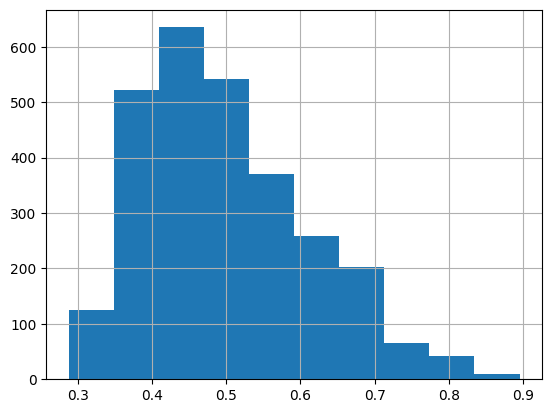

In [89]:
df.gc_content.hist()
plt.show()

#### Distribution of Predictions

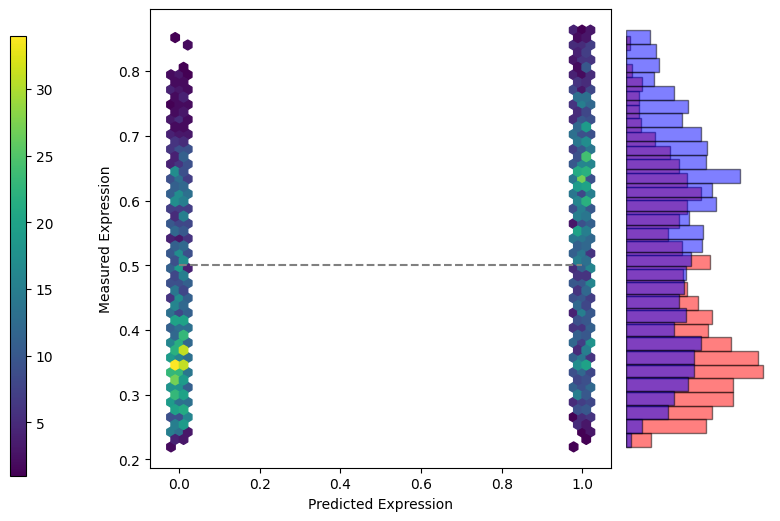

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

category_colors = {
    0: "red",
    1: "blue",
}

# Example data
np.random.seed(42)
x = df['target']
x_jitter = x + np.random.normal(0, 0.02, len(x))
x_jitter = np.clip(x_jitter, x - 0.02, x + 0.02)

y = df['prediction']

# Calculate correlations
pearson_corr, _ = pearsonr(x, y)
spearman_corr, _ = spearmanr(x, y)

# Create the figure
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(4, 4, hspace=0.1, wspace=0.1)

# Main plot
ax_main = fig.add_subplot(gs[1:4, 0:3])
hb = ax_main.hexbin(x_jitter, y, gridsize=50, cmap='viridis', mincnt=1)
# ax_main.plot([x.min(), x.max()], [x.min(), x.max()], 'gray', linestyle='--')
ax_main.plot([x.min(), x.max()], [0.5, 0.5], 'gray', linestyle='--')
ax_main.set_xlabel('Predicted Expression')
ax_main.set_ylabel('Measured Expression')

# Add colorbar on the left
cax = fig.add_axes([-0.05, 0.1, 0.02, 0.55])  # [left, bottom, width, height]
cb = fig.colorbar(hb, cax=cax, orientation='vertical')
# cb.set_label('Density')

# Add correlation text
# n_samples = len(x)
# ax_main.text(0.05, 0.95, f"Pearson's r = {pearson_corr:.3f}\nSpearman's r = {spearman_corr:.2f}\nN = {n_samples}",
#              transform=ax_main.transAxes, verticalalignment='top', fontsize=12)

# Top histogram
# ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
# ax_top.hist(x, bins=30, color='gray', edgecolor='black', alpha=0.7)
# ax_top.axis('off')

# Right histogram (rotated)
ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
# ax_right.hist(y, bins=30, color='gray', edgecolor='black', alpha=0.7, orientation='horizontal')
for category in np.unique(x):
    group_y = y[x == category]
    ax_right.hist(group_y, bins=30, color=category_colors[category], edgecolor='black', alpha=0.5, orientation='horizontal', label=category)

ax_right.axis('off')

plt.show()

#### mRNA specific predictive power

In [97]:
# Compute a Series indicating if an mRNA is only wrongly classified (sum==0)
only_wrong = df.groupby("rna")["correct_pred"].sum() == 0

# Map the boolean result to a new column in the original df
df.loc[:, "all_wrong"] = df["rna"].map(only_wrong)

In [98]:
all_wrong_sample = df[df["all_wrong"]]
all_wrong_sample.describe()

,tissue_ids,target,prediction,prediction_bin,tissue_id,seq_len,5_utr_len,3_utr_len,gc_content
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,14.654912,0.501259,0.500639,0.498741,14.654912,3425.964736,191.037783,555.098237,0.488209
std,8.299891,0.500629,0.138037,0.500629,8.299891,1903.411078,179.219509,381.262016,0.096663
min,0.000000,0.000000,0.238144,0.000000,0.000000,463.000000,8.000000,72.000000,0.314428
25%,8.000000,0.000000,0.378293,0.000000,8.000000,1942.000000,72.000000,300.000000,0.410490
50%,15.000000,1.000000,0.498779,0.000000,15.000000,3095.000000,134.000000,444.000000,0.474474
75%,22.000000,1.000000,0.617698,1.000000,22.000000,4644.000000,275.000000,707.000000,0.540337
max,28.000000,1.000000,0.837216,1.000000,28.000000,8846.000000,1449.000000,1941.000000,0.853093


In [104]:
# Analysis of very confident mistakes
tau = 0.3

confident_mistakes = df[(~df.correct_pred) &
   ( ((df.target == 1) & (df.prediction < tau )) |
     ((df.target == 0) & (df.prediction > 1 - tau))
   )
]

confident_mistakes.groupby("all_wrong").describe()

tissue_ids                                                  target  \
               count       mean       std  min  25%   50%   75%   max  count   
all_wrong                                                                      
False           85.0  11.223529  7.578756  1.0  8.0  11.0  16.0  27.0   85.0   
True            47.0  11.425532  8.707180  1.0  2.0  11.0  16.0  28.0   47.0   

                     ... 3_utr_len         gc_content                      \
               mean  ...       75%     max      count      mean       std   
all_wrong            ...                                                    
False      0.588235  ...     595.0  1756.0       85.0  0.503365  0.122945   
True       0.531915  ...     645.0  1632.0       47.0  0.518166  0.105873   

                                                             
                min       25%       50%       75%       max  
all_wrong                                                    
False      0.310734  0.414683  0.465995  0.582677  0.823782  
True       0.327504  0.422297  0.514894  0.600945  0.724036  

[2 rows x 72 columns]

In [105]:
df[~df.index.isin(confident_mistakes.index)].groupby("all_wrong").seq_len.describe()

,count,mean,std,min,25%,50%,75%,max
all_wrong,,,,,,,,
False,2291.0,3217.473592,1925.308393,355.0,1747.0,2719.0,4428.50,8992.0
True,350.0,3500.288571,1913.205225,463.0,2034.0,3183.5,4691.25,8846.0


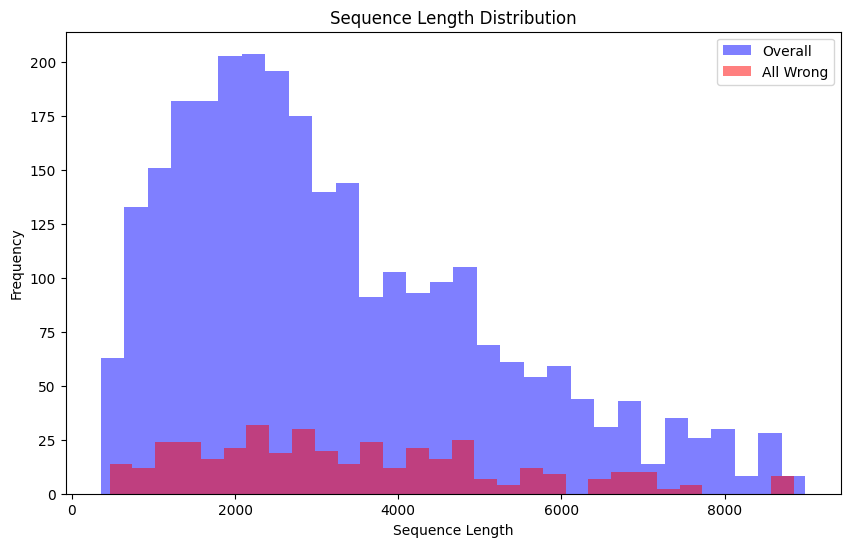

In [113]:
plt.figure(figsize=(10, 6))

# Histogram for all samples
plt.hist(df['seq_len'], bins=30, alpha=0.5, label='Overall', color='blue')

# Histogram for samples where 'all_wrong' is True
plt.hist(df.loc[df['all_wrong'], 'seq_len'], bins=30, alpha=0.5, label='All Wrong', color='red')

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sequence Length Distribution')
plt.show()

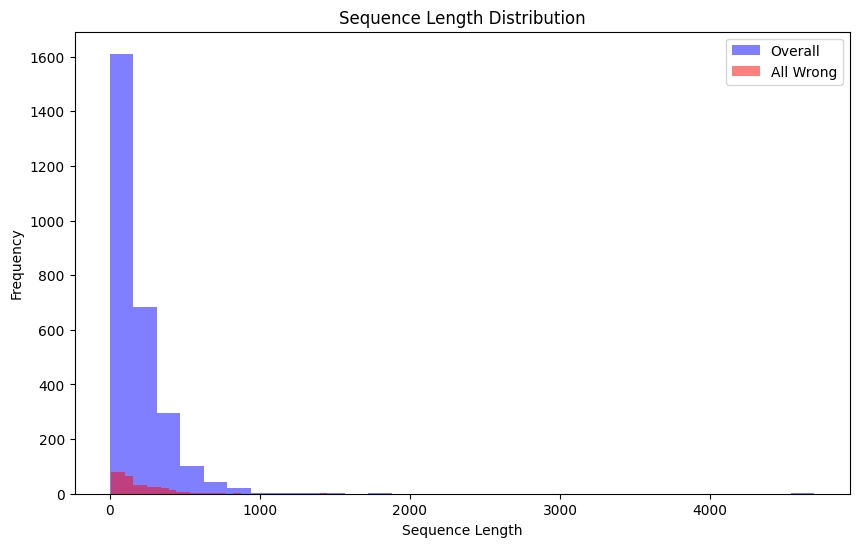

In [115]:
plt.figure(figsize=(10, 6))

# Histogram for all samples
plt.hist(df['5_utr_len'], bins=30, alpha=0.5, label='Overall', color='blue')

# Histogram for samples where 'all_wrong' is True
plt.hist(df.loc[df['all_wrong'], '5_utr_len'], bins=30, alpha=0.5, label='All Wrong', color='red')

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sequence Length Distribution')
plt.show()

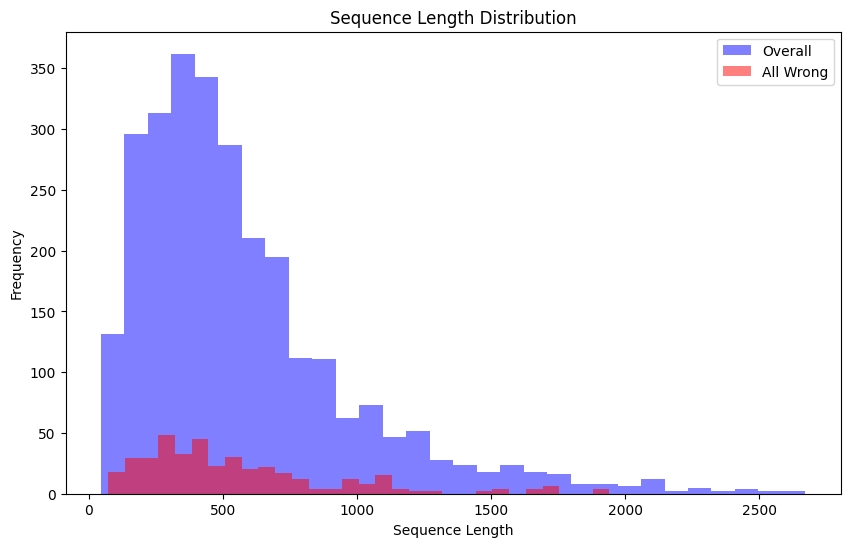

In [116]:
plt.figure(figsize=(10, 6))

# Histogram for all samples
plt.hist(df['3_utr_len'], bins=30, alpha=0.5, label='Overall', color='blue')

# Histogram for samples where 'all_wrong' is True
plt.hist(df.loc[df['all_wrong'], '3_utr_len'], bins=30, alpha=0.5, label='All Wrong', color='red')

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sequence Length Distribution')
plt.show()

## Show correlations

In [32]:
df

,tissue_id,target,prediction,prediction_bin,correct_pred,prediction_freq,prediction_bin_freq,correct_pred_freq,rna,coding_area,seq_len,5_utr_len,3_utr_len
0,6,1,0.340291,0,False,0.161814,0,False,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193,209,426
1,16,0,0.534514,1,False,0.559810,1,False,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193,209,426
2,1,1,0.310510,0,False,0.279136,0,False,TCCCCTTGGCCCTCCCTTACCGCACGGTCTCTGGCCAGCCGTGGCC...,5555555555555555555555555555555555555555555555...,1761,142,416
3,8,0,0.282197,0,True,0.274266,0,True,TCCCCTTGGCCCTCCCTTACCGCACGGTCTCTGGCCAGCCGTGGCC...,5555555555555555555555555555555555555555555555...,1761,142,416
4,3,1,0.300825,0,False,0.213903,0,False,GCGTCCGCGCCATCAGGCCCGAGATAGCGGCGAGGTCCGCTTTCAG...,5555555555555555555555555555555555555555555555...,2767,49,310
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,24,0,0.642258,1,False,0.415386,0,False,CTCGGCGATGAGCTAAGACGCTGTTTCAGAGCGTTTGGGTCCTCTG...,5555555555555555555555555555555555555555555555...,1998,127,479
2769,21,0,0.781745,1,False,0.814679,1,False,ACATTGGGGCGGGATGTGGGAGCGGCTGAACTGCGCAGCAGAGGAC...,5555555555555123123123123123123123123123123123...,3595,13,592
2770,23,1,0.582704,1,True,0.601535,1,True,ACATTGGGGCGGGATGTGGGAGCGGCTGAACTGCGCAGCAGAGGAC...,5555555555555123123123123123123123123123123123...,3595,13,592
2771,8,1,0.273913,0,False,0.400855,0,False,GGAGTCTGCGCTCTGGTTCGGGCTGCGGCTGCGGCTGCGGCTGCGG...,5555555555555555555555555555555555555555555555...,8143,201,745


In [181]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

def plot_correlations(df, feature_name, tissue_id=None):
    df_subset = df
    if tissue_id is not None:
        df_subset = df[df.tissue_id.isin([tissue_id])].copy()

    y_true = df_subset.target
    y_pred = df_subset.prediction
    feature = df_subset[feature_name]

    print("Tissue displayed:", TISSUES_DICT[tissue_id], f"({tissue_id})")
    if tissue_id in tissue_numbers["GC"]:
        print("NOTE: Tissue GC boosted acc to Hernandez et al!")
    if tissue_id in tissue_numbers["AT"]:
        print("NOTE: Tissue AT boosted acc to Hernandez et al!")
    print("Counts per target:", df.groupby(["tissue_id", "target"]).prediction.count().loc[tissue_id])
    print("Correlation", np.corrcoef(feature, y_pred)[0, 1])

    # Define colors for class 0 and 1
    color_map = {0: 'tab:blue', 1: 'tab:red'}
    colors = y_true.map(color_map)

    # Compute Pearson correlation using NumPy
    r = np.corrcoef(feature, y_pred)[0, 1]

    plt.figure(figsize=(8, 6))

    # Shaded regions
    if max(y_pred) > 0.5:
        plt.axhspan(0.5, max(y_pred) * 1.1, color='red', alpha=0.05)
    if min(y_pred) < 0.5:
        plt.axhspan(min(y_pred) * 0.9, 0.5, color='blue', alpha=0.05)

    # Scatter plot
    plt.scatter(feature, y_pred, c=colors, alpha=0.8, linewidth=0.5)

    # Axis labels and threshold line
    plt.xlabel(feature_name)
    plt.ylabel("Predicted Score")
    plt.plot([min(feature)*0.9, max(feature)*1.1], [0.5, 0.5], color='grey', linestyle='--')
    plt.title("Predicted Score vs. % of GC-ending codons")

    # Add Pearson correlation text
    plt.text(0.05, 0.95, f"Pearson r = {r:.2f}", transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Legend
    legend_elements = [
        mpatches.Patch(color='tab:red', label='High PTR (1)'),
        mpatches.Patch(color='tab:blue', label='Low PTR (0)')
    ]
    plt.legend(handles=legend_elements, title="True Class", loc="best")

    plt.tight_layout()
    plt.show()

In [260]:
nr_iter = iter(range(29))

In [290]:
# blue should be below the line
# plot_correlations(df, "gc_content", next(nr_iter))
plot_correlations(df, "seq_len", next(nr_iter))  # seq_len, 5_utr_len, 3_utr_len, cds_len

StopIteration: 

Tissue displayed: Kidney (11)
NOTE: Tissue GC boosted acc to Hernandez et al!
Counts per target: target
0    66
1    62
Name: prediction, dtype: int64
Correlation [1.         0.73605699]


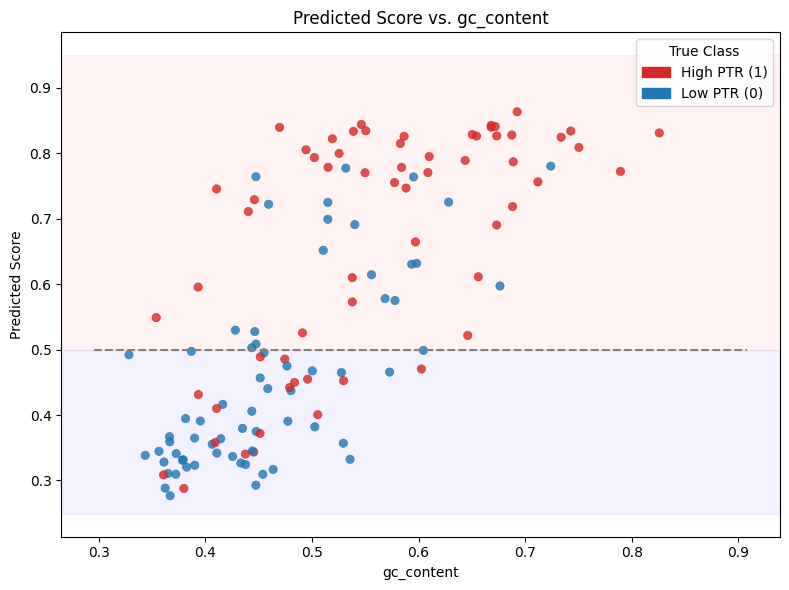

In [152]:
# KIDNEY (GC BOOSTED)
plot_correlations(df, "gc_content", 11)  # gc_content, seq_len

Tissue displayed: Lung (13)
NOTE: Tissue AT boosted acc to Hernandez et al!
Counts per target: target
0     55
1    103
Name: prediction, dtype: int64
Correlation -0.6127299863078671


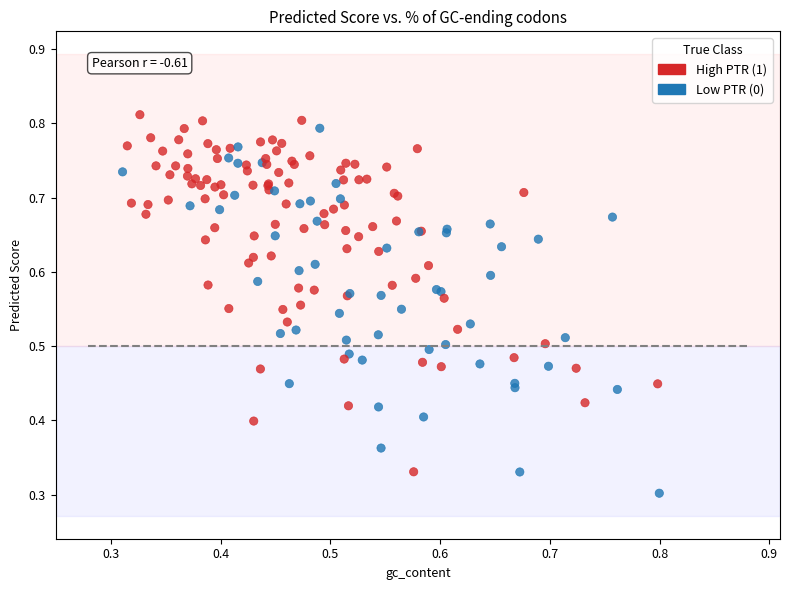

In [222]:
# LUNG (AT BOOSTED)
plot_correlations(df, "gc_content", 13)  # gc_content, seq_len

#### Correlation were model failed for both (low- and high-PTR) sequences

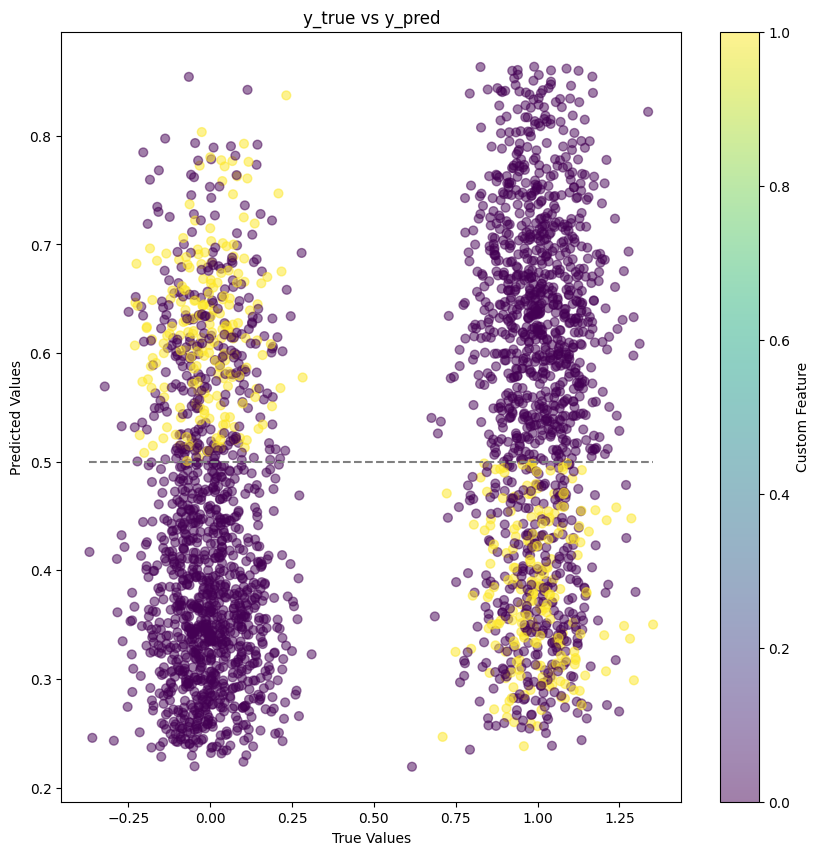

In [154]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))

y_true = df.target + np.random.normal(0, 0.1, len(df.target))
y_pred = df.prediction
seq_lengths = df.seq_len

cmap = plt.cm.viridis  # Choose a colormap (e.g., viridis, plasma, etc.)

# Scatter plot with colors

scatter = plt.scatter(y_true, y_pred, alpha=0.5, s=40, c=df.all_wrong, cmap=cmap)  # ALL_WRONG

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('y_true vs y_pred')

# Add a colorbar associated with the scatter plot
cbar = plt.colorbar(scatter)
cbar.set_label('Custom Feature')

min_val = min(min(y_true), min(y_pred))
max_val = max(max(y_true), max(y_pred))
plt.plot([min_val, max_val], [0.5, 0.5], color='grey', linestyle='--')

plt.show()

# Does the model mainly fail for specific sequences (yellow: prediction for both low and high ptr was wrong)

#### Correlations with sequence length

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def plot_corr_with_seq_len(df, selected_tissues=[]):
    plt.figure(figsize=(10, 10))
    if selected_tissues:
        df = df[df.tissue_id.isin(selected_tissues)].copy()
    
    y_true = df.target + np.random.normal(0, 0.1, len(df.target))
    y_pred = df.prediction
    seq_lengths = df.seq_len
    
    # Normalize sequence lengths for coloring
    norm = plt.Normalize(min(seq_lengths), max(seq_lengths))
    cmap = plt.cm.viridis  # Choose a colormap (e.g., viridis, plasma, etc.)
    
    # Scatter plot with colors
    scatter = plt.scatter(y_true, y_pred, alpha=0.5, s=40, c=seq_lengths, cmap=cmap, norm=norm)
    
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('y_true vs y_pred')
    
    # Add a colorbar associated with the scatter plot
    cbar = plt.colorbar(scatter)
    cbar.set_label('Sequence Length')
    
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [0.5, 0.5], color='grey', linestyle='--')
    
    plt.show()

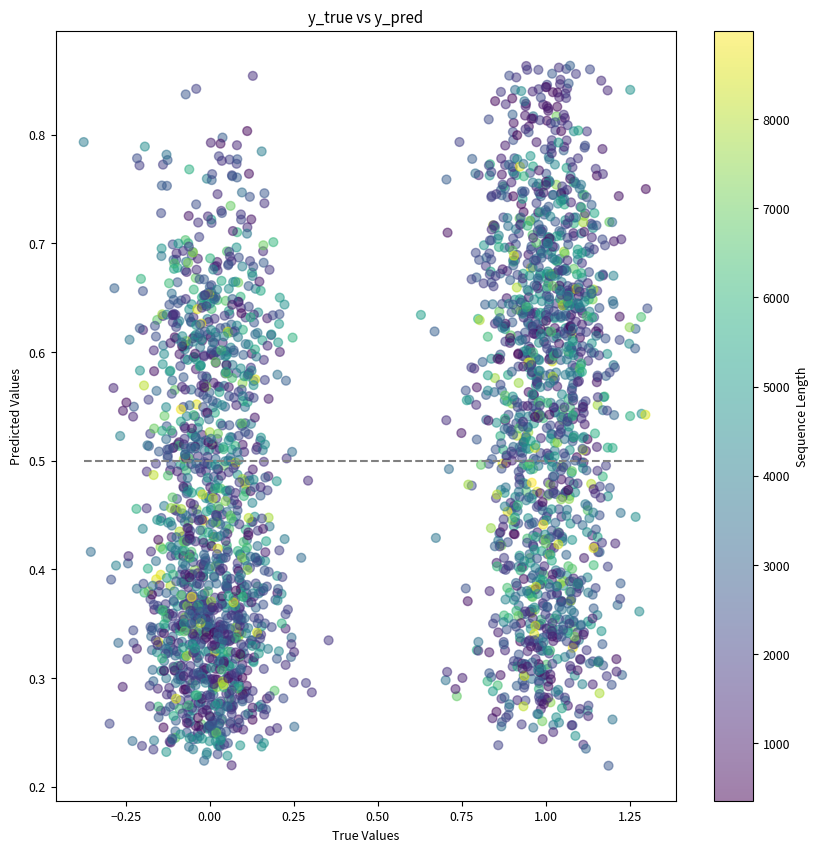

In [72]:
import matplotlib.pyplot as plt
import numpy as np

plot_corr_with_seq_len(df)
# FREQ

In [157]:
nr_iter = iter(range(28))

[0]
target
0    24
1    23
Name: prediction, dtype: int64


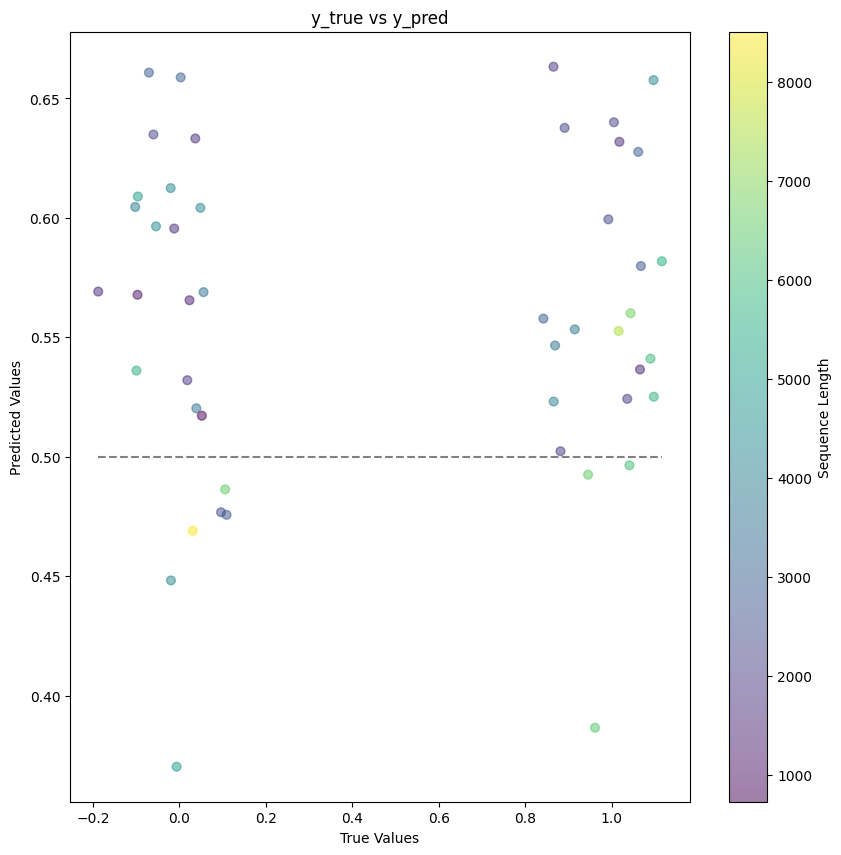

In [158]:
nr = next(nr_iter)
selected_tissues = [nr]
print(selected_tissues)
print(df.groupby(["tissue_id", "target"]).prediction.count().loc[nr])

plot_corr_with_seq_len(df, selected_tissues)

#### Correlation with GC content

In [166]:
import matplotlib.pyplot as plt
import numpy as np

# Filter dataframe
def plot_corr_with_gc_content(df, selected_tissues=None):
    plt.figure(figsize=(10, 10))
    if selected_tissues:
        df = df[df.tissue_id.isin(selected_tissues)].copy()
    
    y_true = df.target + np.random.normal(0, 0.1, len(df.target))
    y_pred = df.prediction
    seq_lengths = df.gc_content
    
    # Normalize sequence lengths for coloring
    norm = plt.Normalize(min(seq_lengths), max(seq_lengths))
    cmap = plt.cm.viridis  # Choose a colormap (e.g., viridis, plasma, etc.)
    
    # Scatter plot with colors
    scatter = plt.scatter(y_true, y_pred, alpha=0.4, s=40, c=seq_lengths, cmap=cmap, norm=norm)
    
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('y_true vs y_pred')
    
    # Add a colorbar associated with the scatter plot
    cbar = plt.colorbar(scatter)
    cbar.set_label('GC Content')
    
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [0.5, 0.5], color='grey', linestyle='--')
    
    plt.show()

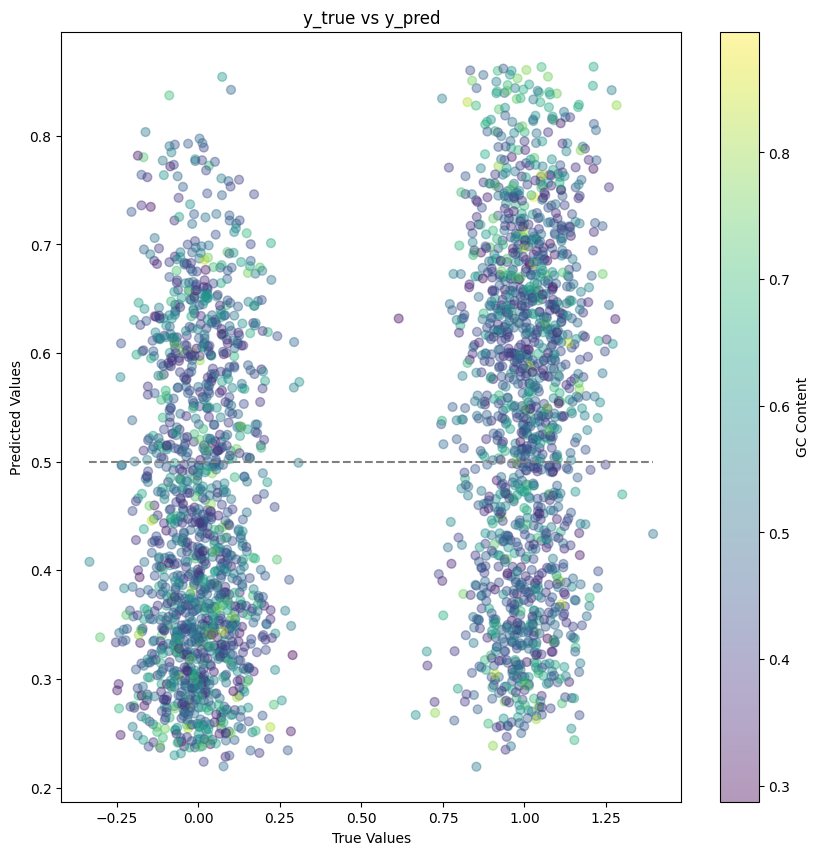

In [167]:
plot_corr_with_gc_content(df)

In [160]:
nr_iter = iter(range(29))

[1, 2, 3, 4, 5]


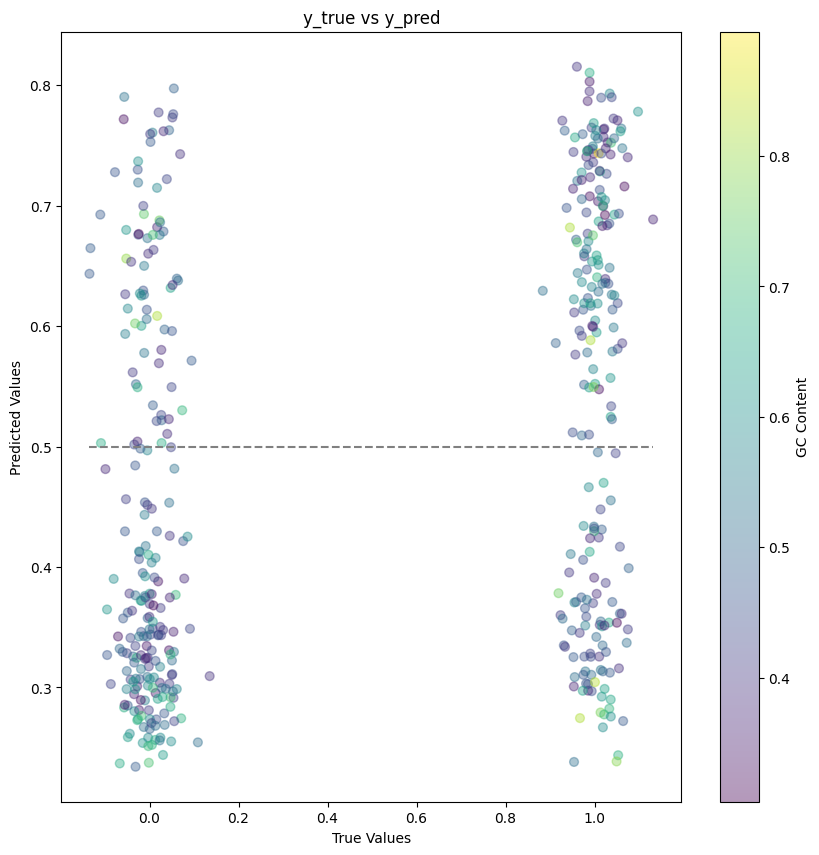

In [161]:
# Choose subset of tissue IDs to analyze

# nr = next(nr_iter)
selected_tissues = [1,2,3,4,5]
print(selected_tissues)
# print(df.groupby(["tissue_id", "target"]).prediction.count().loc[nr])

plot_corr_with_gc_content(df, selected_tissues)

#### Correlation among tissue ids

In [211]:
nr_iter = iter(range(29))

Tissue displayed: Adrenal (0)
[[ 6 18]
 [ 3 20]]


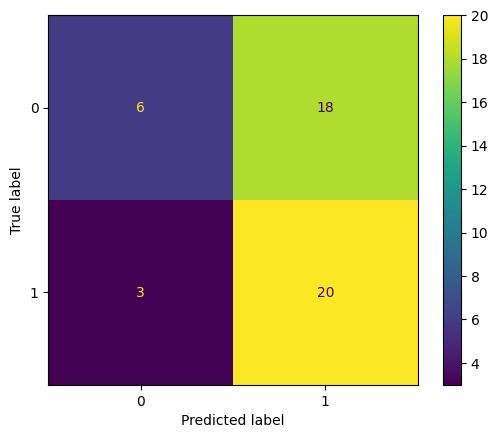

In [212]:
# Confusion matrix per tissue
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tissue_id = next(nr_iter)

print("Tissue displayed:", TISSUES_DICT[tissue_id], f"({tissue_id})")
subset_df = df[df.tissue_id.isin([tissue_id])].copy()

if tissue_id in tissue_numbers["GC"]:
        print("NOTE: Tissue GC boosted acc to Hernandez et al!")
if tissue_id in tissue_numbers["AT"]:
    print("NOTE: Tissue AT boosted acc to Hernandez et al!")

cm = confusion_matrix(subset_df.target, subset_df.prediction_bin)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [171]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def corr_among_tissues(selected_tissues):
    # Filter dataframe
    subset_df = df[df.tissue_id.isin(selected_tissues)].copy()

    # Check if the subset is non-empty
    if subset_df.empty:
        raise ValueError("No data available for the selected tissue IDs.")

    plt.figure(figsize=(10, 10))

    # Generate y_true (adding a small uniform noise) and y_pred
    y_true = subset_df.target + np.random.uniform(0, 0.8, len(subset_df))
    y_pred = subset_df.prediction

    # Fix the y-scale to [0, 1]
    #plt.ylim(0, 1)

    # Get unique tissue ids and sort them
    unique_tissues = sorted(subset_df.tissue_id.unique())

    # Define a list of markers to cycle through
    markers = ['o', 's', '^', 'D']#, 'v']#, 'P', '*', 'X', 'h', 'H', '8', 'p', 'd']
    # Get a colormap with as many distinct colors as there are tissues (using a colormap that supports many colors)
    # cmap = plt.get_cmap('nipy_spectral', len(unique_tissues))
    cmap = plt.get_cmap('tab10' if len(unique_tissues) <= 10 else 'tab20', max(len(unique_tissues), 1))

    # Plot each tissue's data separately with its own color and marker
    for i, tissue in enumerate(unique_tissues):
        mask = subset_df.tissue_id == tissue
        plt.scatter(
            y_true[mask],
            y_pred[mask],
            label=f'Tissue {tissue}',
            alpha=0.5,
            s=40,
            c=[cmap(i)],
            marker=markers[i % len(markers)]
        )

    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('y_true vs y_pred by Selected Tissue IDs')

    # Add a legend outside the plot area for clarity
    plt.legend(title='Tissue ID', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Optionally, add a horizontal line at y = 0.5 for reference
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [0.5, 0.5], color='grey', linestyle='--')

    plt.tight_layout()
    plt.show()

In [172]:
nr_iter = iter(range(29))

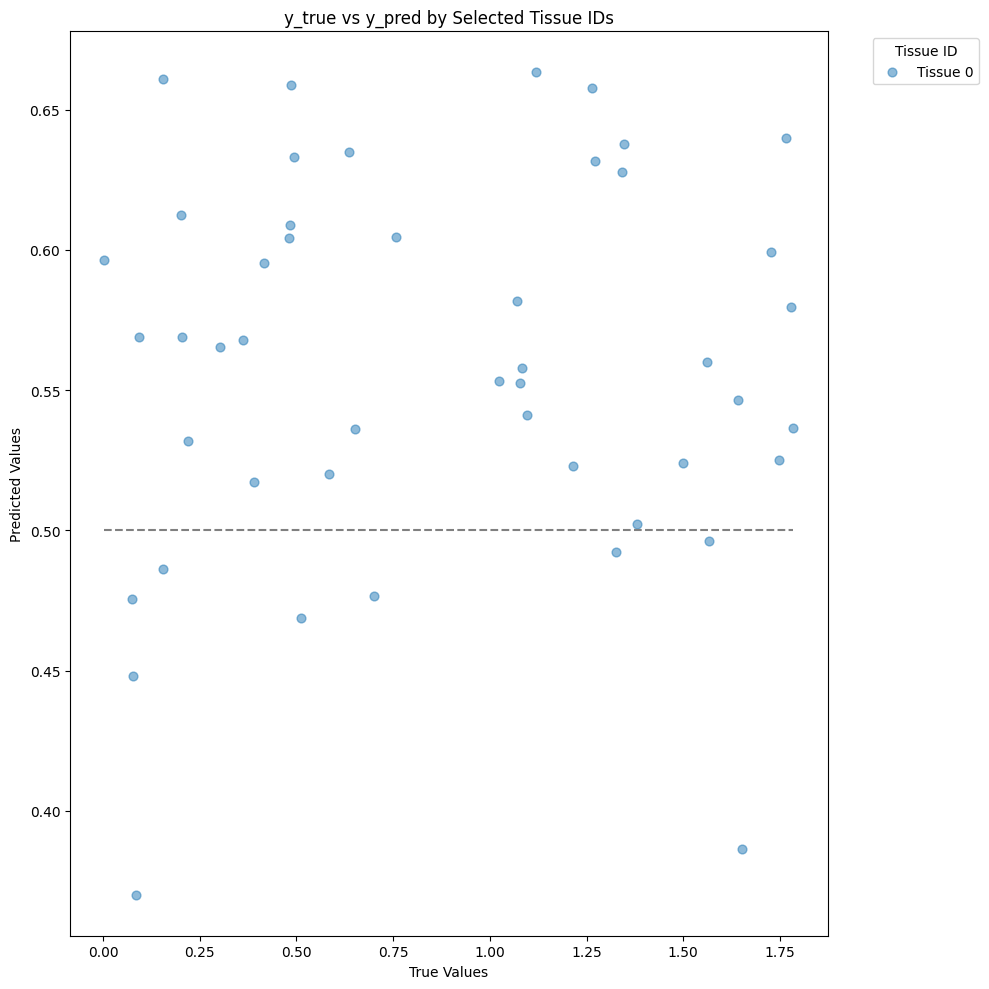

In [173]:
corr_among_tissues([next(nr_iter)])

In [ ]:
# Choose subset of tissue IDs to analyze
#selected_tissues = list(range(10))
selected_tissues = list(range(10,20))
#selected_tissues = list(range(20,29))

corr_among_tissues(selected_tissues)

#### Correlation with tissue type

In [240]:
# for vis see above
df.groupby(["tissue_id", "target"]).prediction.count()

tissue_id  target
0          0         18
           1         29
1          0         74
           1         31
2          0         39
           1         86
3          0         39
           1         31
4          0         28
           1         21
5          0         32
           1         23
6          0         45
           1         26
7          0         28
           1         40
8          0         84
           1         39
9          0         29
           1         17
10         0         61
           1         46
11         0         44
           1         55
12         0         47
           1         42
13         0         41
           1         84
14         0         33
           1         45
15         0         59
           1         52
16         0         79
           1         49
17         0         34
           1         37
18         0         33
           1         28
19         0         25
           1         35
20         0         3

In [245]:
# If downsample tissue wise to less dominant class, number of samples in val set would shrink to 1896 from 2352
ls = df.groupby(["tissue_id", "target"]).prediction.count().to_list()
tpls = [(ls[i], ls[i+1]) for i in range(0, len(ls), 2)]
2 * sum([min(tpl) for tpl in tpls])

1896

In [248]:
sum(ls)

2352

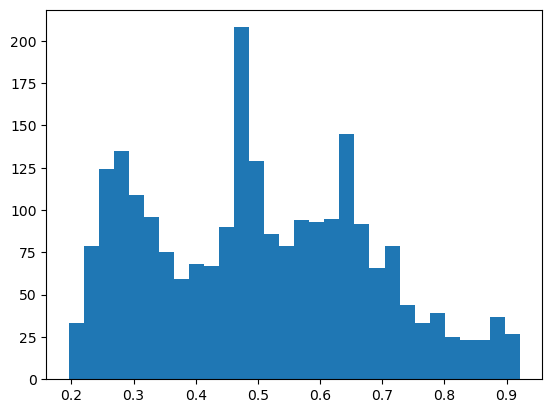

In [250]:
plt.hist(df.prediction, bins=30)
plt.show()